In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget
from multiprocessing import Pool
from scipy.stats import norm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


import h5py
import pandas as pd
from rich import print as pprint
from sourcesep.utils.config import load_config

paths = load_config(dataset_key='all')
f = h5py.File(paths['root'] / 'HSFP_670128_2023-04-27_data_preprocessed.hdf5', 'r')
print(f.keys())

xj = {}
for j in np.argsort(f['Lasers'][:]):
    xj[j]  = f[f'Channel{j+1}'][:].astype(float)

t = f['Time'][:]
l = f['Wavelength'][:]
lasers = f['Lasers'][:][np.argsort(f['Lasers'][:])]

print(f'\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz')
print(f'length of recording: {np.max(t)-np.min(t):0.2f} seconds')
print(f'\neach channel has dimensions of {xj[0].shape}')
print(f'min. wavelength: {np.min(l):0.2f} nm')
print(f'max. wavelength: {np.max(l):0.2f} nm')


Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Lasers', 'Time', 'Wavelength']>

sampling frequency: 23.99 Hz
length of recording: 448.23 seconds

each channel has dimensions of (10752, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


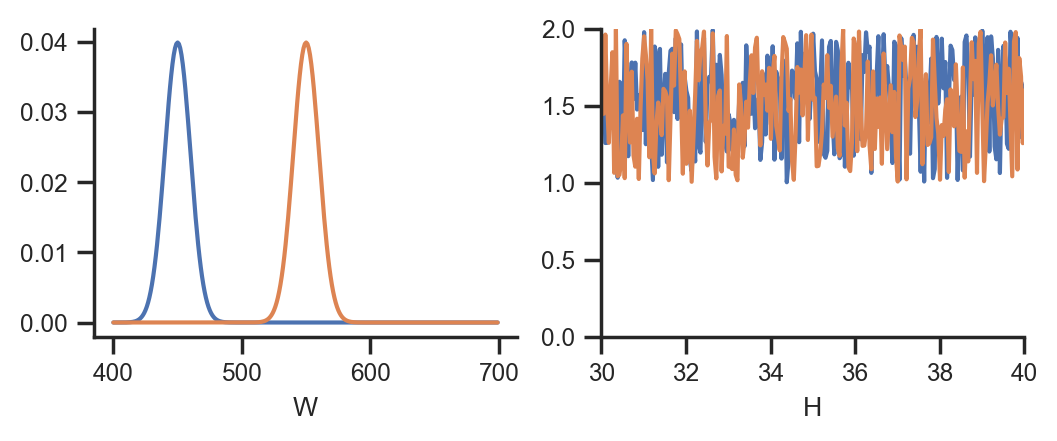

In [33]:
W_true = np.concatenate([norm.pdf(l,loc=450, scale=10).reshape(1,-1),
                    norm.pdf(l,loc=550, scale=10).reshape(1,-1)], axis = 0)

H_true = np.empty((t.size, 2))
H_true = np.random.rand(*H_true.shape) + 1

# set color scheme
cmap = sns.color_palette('colorblind', n_colors=lasers.size)

f, ax = plt.subplots(1,2,figsize=(6,2))
ax[0].plot(l,W_true.T)
ax[0].set(xlabel='W')
ax[1].plot(t, H_true)
ax[1].set(xlabel='H', ylim = (0,2), xlim = (30,40))
plt.show()

In [34]:
X_true = H_true @ W_true
print('W_true:', W_true.shape)
print('H_true:', H_true.shape)
print('X_true:', X_true.shape)

# without bias
X_true_ = (H_true - 1) @ W_true


W_true: (2, 300)
H_true: (10752, 2)
X_true: (10752, 300)


In [35]:
from sklearn.decomposition import NMF

n_components = 2
model = NMF(n_components=n_components, init='random',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=10000, random_state=None,
            alpha_W=1, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

W_fit = model.fit_transform(X_true.T)
H_fit = model.components_

W_fit = W_fit.T
H_fit = H_fit.T

/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


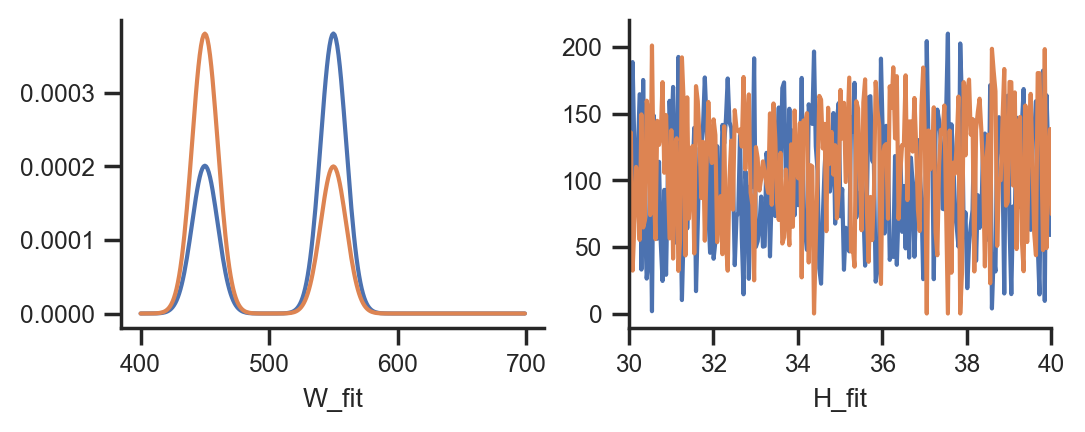

Error:  0.024640796493430348

In [36]:
f, ax = plt.subplots(1, 2, figsize=(6,2))
ax[0].plot(l, W_fit.T[:,::-1])
ax[0].set(xlabel='W_fit')
ax[1].plot(t, H_fit[:,::-1])
ax[1].set(xlabel='H_fit', xlim = (30,40))
plt.show()

err = np.abs((H_fit@W_fit - H_true@W_true))
pltj = [H_true@W_true,H_fit@W_fit,err]
pprint("Error: ", np.linalg.norm(err, ord='fro'))

In [37]:
n_components = 2
model = NMF(n_components=n_components, init='random',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=10000, random_state=None,
            alpha_W=1, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

W_fit = model.fit_transform(X_true_.T)
H_fit = model.components_

W_fit = W_fit.T
H_fit = H_fit.T

/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


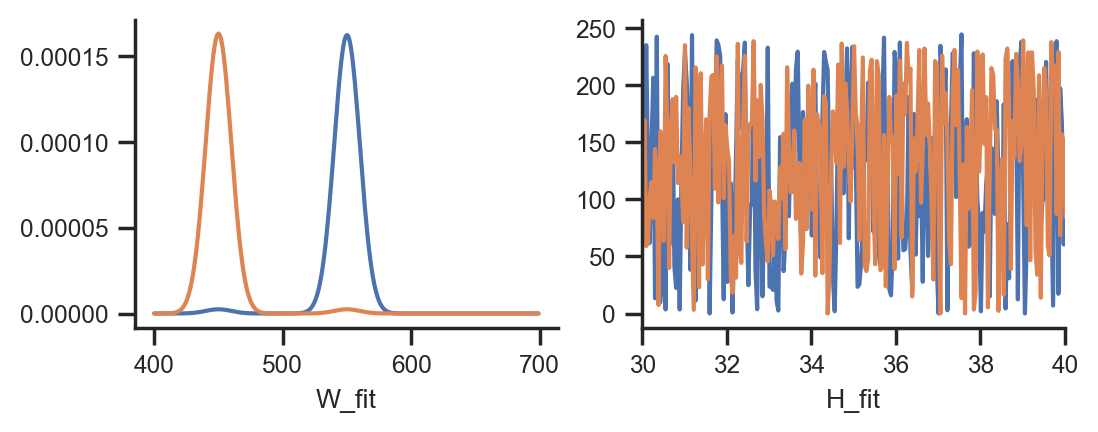

Error:  0.014462322207638831

In [38]:
f, ax = plt.subplots(1, 2, figsize=(6,2))
ax[0].plot(l, W_fit.T[:,::-1])
ax[0].set(xlabel='W_fit')
ax[1].plot(t, H_fit[:,::-1])
ax[1].set(xlabel='H_fit', xlim = (30,40))
plt.show()

err = np.abs((H_fit@W_fit - (H_true - 1)@W_true))
pltj = [H_true@W_true,H_fit@W_fit,err]
pprint("Error: ", np.linalg.norm(err, ord='fro'))

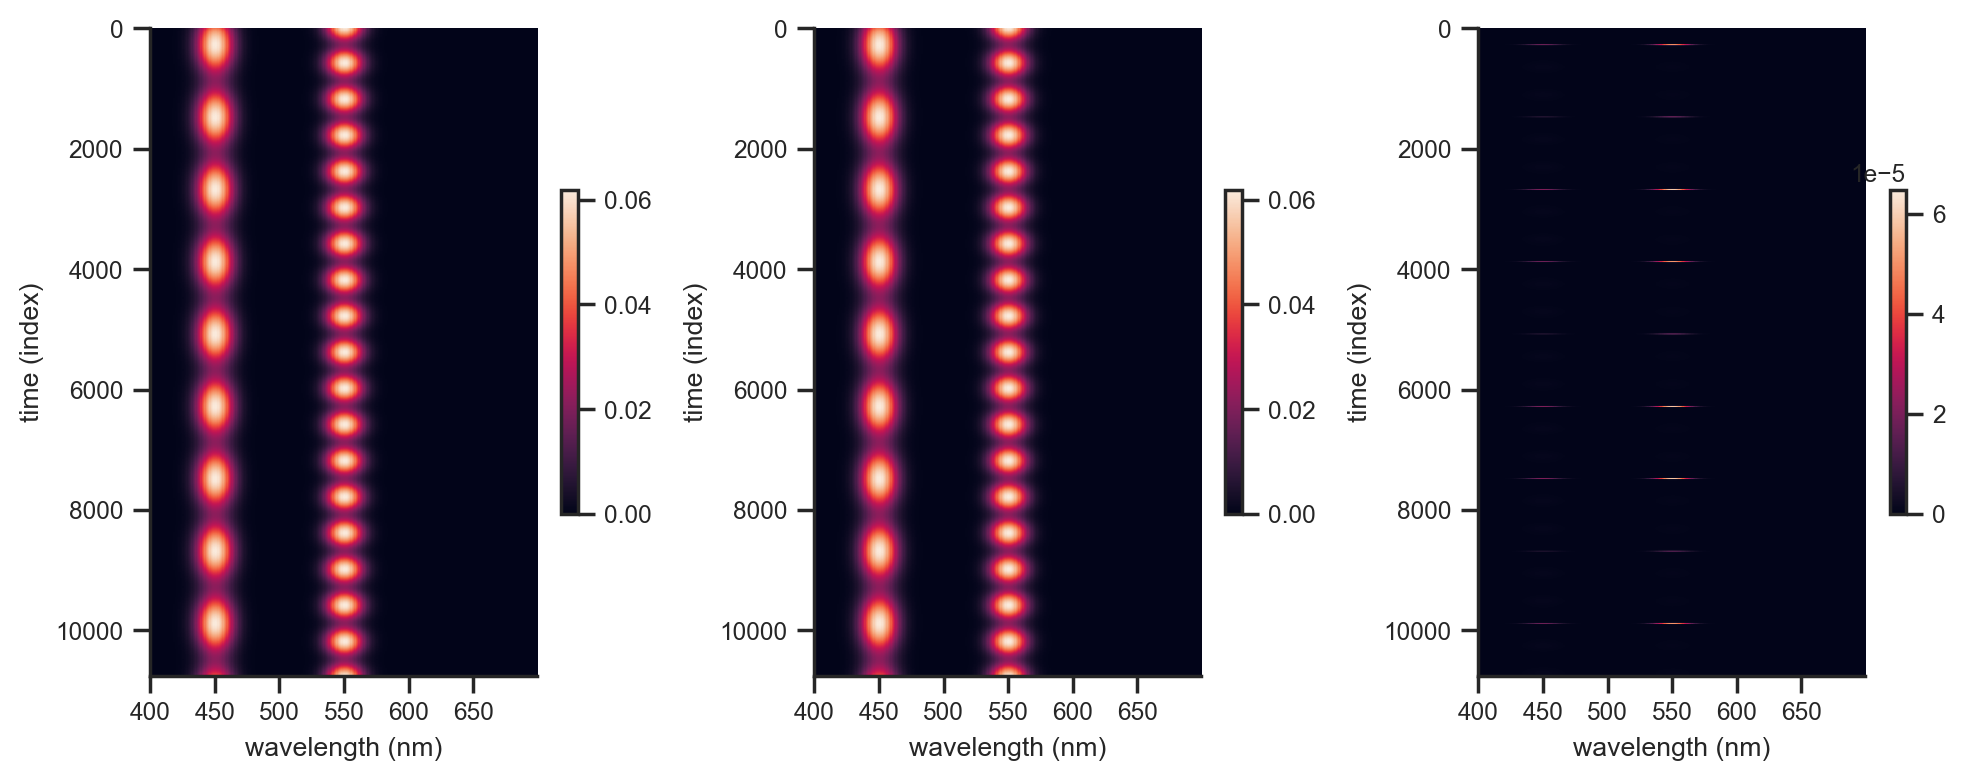

In [7]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(pltj[i],
                            interpolation='nearest',
                            aspect='auto'),
               ax=ax[i], shrink=0.5)
    ax[i].grid(False)
    ax[i].set(xlabel='wavelength (nm)', ylabel='time (index)')
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])
plt.tight_layout()

In [8]:
# X: p x q
# W: p x r
# H: r x q

In [9]:
# Multiplicative update rule NMF:
def nmf_mult(X, W, H, n_steps = 100):
    for _ in range(n_steps):
        W = (W / (W @ H @ H.T)) * (X @ H.T)
        H = (H / (W.T @ W @ H)) * (W.T @ X)

    return W, H

In [10]:
W = W_true.T.copy()
H = H_true.T.copy()
X = W @ H

In [11]:

W_noise = np.random.rand(W.shape[0],W.shape[1])*0.01
W_noise[W_noise<=0]=0.0001
W_init = W + W_noise

H_noise = np.random.rand(H.shape[0],H.shape[1])*0.01
H_noise[H_noise<=0]=0.0001
H_init = H + H_noise

In [12]:
W_fit, H_fit = nmf_mult(X, W_init, H_init, n_steps = 1000)

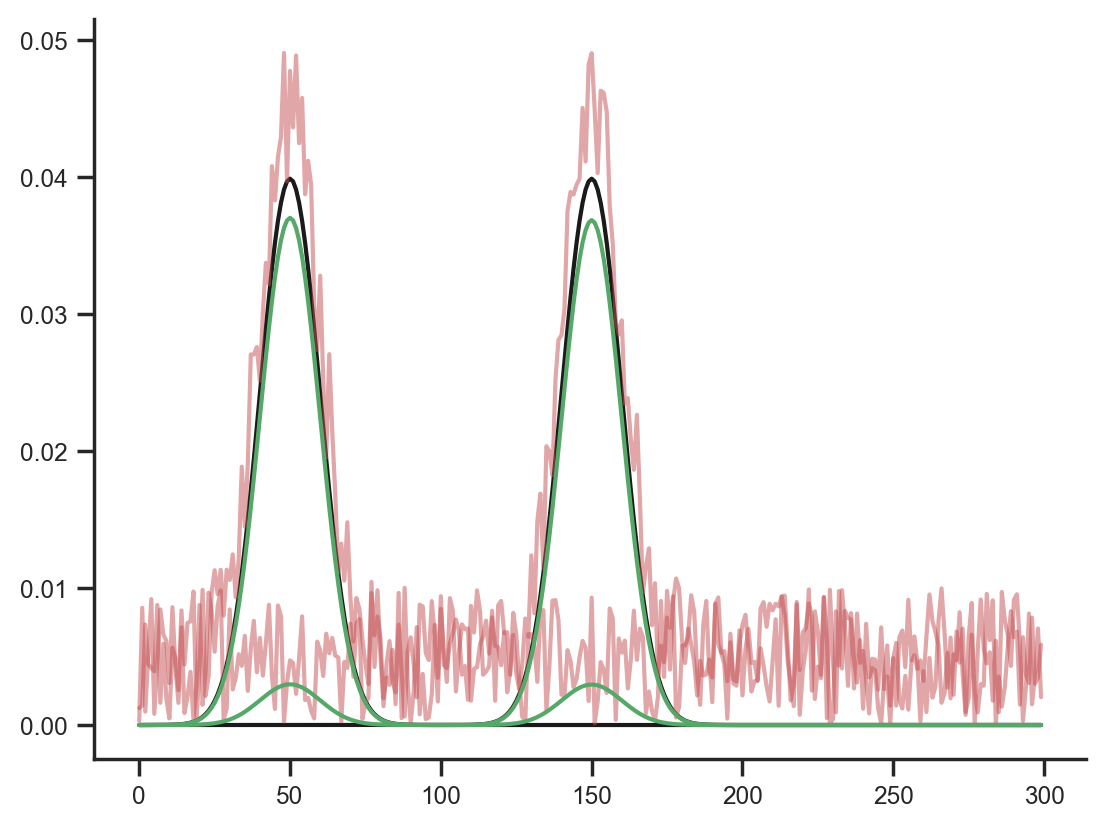

In [13]:
plt.plot(W, '-k')
plt.plot(W_init, '-r', alpha=0.5)
plt.plot(W_fit, '-g')

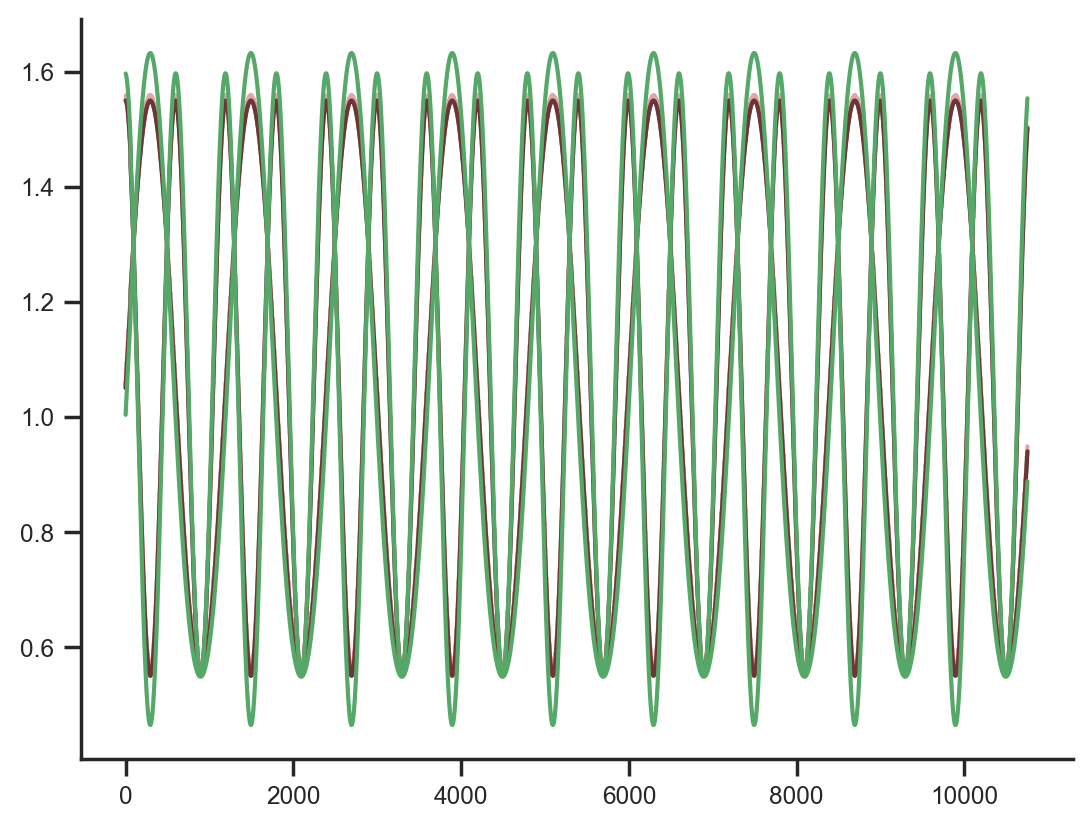

In [14]:
plt.plot(H.T, '-k')
plt.plot(H_init.T, '-r', alpha=0.5)
plt.plot(H_fit.T, '-g')

In [15]:
# Hoyers sparseity critereon
def sparsity_criterion(Y):
    """Hoyers sparsity criterion"""
    eps = 1e-10
    n = Y.shape[1]
    s = np.sqrt(n) - np.sum(np.abs(Y), axis=1) / np.linalg.norm(Y, axis=1)
    return np.sum(s) / (np.sqrt(n) - eps)

In [16]:
%%timeit
nd = np.linalg.multi_dot([W.T, W, H])

35.9 µs ± 557 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
%%timeit
nd_ = W.T @ W @ H

23.4 µs ± 55.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
# NMF variants:
# vanilla multiplicative updates
# HALS
# HALS with sparsity constraints
# Sparsity parameter tuning?
# Poisson NMF
# Separability of H and W, and relation to uniqueness
# Guarantees and algorithm from blind source sepsaration paper
# Guarantees and algorithm from hyperspectral source separation paper

# For multiple indicators, convolutive NMF seems like it would naturally incorporate laser on-off sequence.

# Diagnostics:
# explained variance
# correlation
# residual plots

# Arguments for why the laser source separation problem is not the right problem:
# The separation is in frequency domain
# df/f eliminates the color spectrum information (this is what we have priors on in the multi-indicator case).
# we have a pretty good starting point
# the problem of when is it good enough, remains.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


def sparsify(x, l1, l2, verbose=True):

    s_int = []
    s_int.append(x.copy())
    dim = x.size
    assert (0 < l2) and (l2 <= l1) and (
        l1 <= np.sqrt(dim) * l2), "not feasible"

    s = np.copy(x) + (l1 - np.sum(x)) / dim
    Z = np.zeros(s.shape, dtype=bool)
    s_int.append(s.copy())
    while True:
        m = l1/(dim-Z.sum()) * np.ones_like(s)
        m[Z] = 0.0

        # quadratic eqn coefs for alpha
        # w = s-m
        # v = s
        a = np.sum((s-m)**2)
        b = 2*np.dot(m, s-m)
        c = np.sum(m**2) - l2**2

        alpha = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

        s = m + alpha * (s - m)
        s_int.append(s.copy())

        if verbose:
            print(f'l1 norm: {np.linalg.norm(s, ord=1):0.3f}')
            print(f'l2 norm: {np.linalg.norm(s, ord=2):0.3f}')
            print(f'l2 (x - s): {np.linalg.norm(x - s, ord=2):0.3f}')
            print(f'n zeros: {dim-Z.sum()}')
            print('-----------------')
        if np.all(s >= 0):
            return s, s_int

        Z = s < 0
        s[Z] = 0
        temp = s.sum()
        c = (temp - l1)/(dim - Z.sum())
        s[~Z] = s[~Z] - c

In [20]:
x = 1.5*np.array([0.75,1.5])
l1 = 1.2
l2 = 1.0
x_norm, x_int, = sparsify(x, l1, l2)


l1 norm: 1.200
l2 norm: 1.000
l2 (x - s): 1.561
n zeros: 2
-----------------


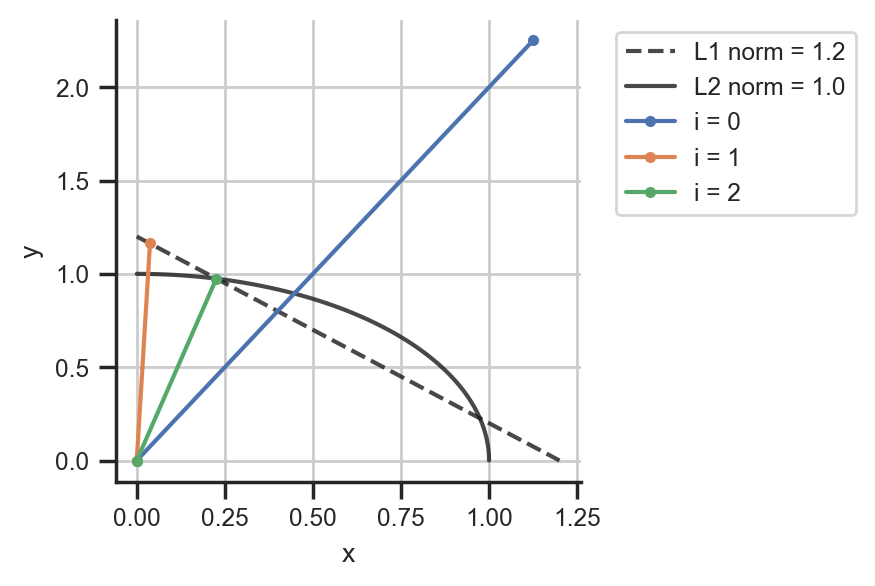

In [21]:
theta = np.linspace(0,np.pi/2,100)
f, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot([0,l1],[l1,0],'--k', alpha=0.8, label=f'L1 norm = {l1}')
ax.plot(l2*np.cos(theta), l2*np.sin(theta),'-k', alpha=0.8, label=f'L2 norm = {l2}')
for i, v in enumerate(x_int):
    ax.plot([0,v[0]], [0,v[1]], '.-', alpha=1, label=f'i = {i}')
ax.set(xlabel='x', ylabel='y')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
plt.show()